In [1]:
import importlib
import json
import os
import re
import sys
from datetime import datetime
from pathlib import Path
from PIL import ImageFont, ImageDraw
from zoneinfo import ZoneInfo
from tqdm import tqdm

import dotenv
import hydra
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision.transforms as T
from PIL import Image
from pytorch_grad_cam import (
    GradCAM,
)
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.utils import draw_segmentation_masks, make_grid  # type: ignore[import-untyped]

import wandb
from inz.data.data_module import XBDDataModule
from inz.data.data_module_frnet import FRNetModule
from inz.data.event import Event, Hold, Test, Tier1, Tier3

sys.path.append("inz/farseg")
sys.path.append("inz/dahitra")
sys.path.append("inz/xview2_strong_baseline")

In [2]:
n_classes = 5

In [3]:
def get_events_hist(events, include_bcgr=False):
    hist = torch.zeros((n_classes,))
    dm = XBDDataModule(
        path=Path("data/xBD_processed_512"),
        drop_unclassified_channel=True,
        events=events,
        val_fraction=0.0,
        test_fraction=0.0,
        train_batch_size=64,
        val_batch_size=1,
        test_batch_size=1,
        num_workers=2,
    )
    dm.prepare_data()
    dm.setup("eval")
    for batch in tqdm(dm.train_dataloader()):
        _, _, _, masks = batch
        masks = masks.argmax(dim=1).view(-1)
        bc = torch.bincount(masks, minlength=n_classes)
        hist += bc
    if not include_bcgr:
        hist = hist[1:]
    del dm
    return hist, hist / hist.sum()

In [4]:
densities = []

for e in [
    # {Tier1: [Event.santa_rosa_wildfire], Hold: [Event.santa_rosa_wildfire], Test: [Event.santa_rosa_wildfire]},
    # {Tier3: [Event.woolsey_fire]},
    # {Tier3: [Event.pinery_bushfire]},
    # {Tier1: [Event.socal_fire], Hold: [Event.socal_fire], Test: [Event.socal_fire]},
    # {Tier3: [Event.portugal_wildfire]},
    {Tier1: [Event.hurricane_harvey], Hold: [Event.hurricane_harvey], Test: [Event.hurricane_harvey]},
    {Tier1: [Event.hurricane_michael], Hold: [Event.hurricane_michael], Test: [Event.hurricane_michael]},
    {Tier1: [Event.midwest_flooding], Hold: [Event.midwest_flooding], Test: [Event.midwest_flooding]},
    {Tier3: [Event.nepal_flooding]},
]:
    densities.append(get_events_hist(e)[1])

100%|██████████| 39/39 [01:11<00:00,  1.82s/it]


In [5]:
import matplotlib.pyplot as plt


def plot_pie_charts(densities, labels):
    fig, ax = plt.subplots(ncols=len(densities), figsize=(16, 6), dpi=300)

    for i, (d, l) in enumerate(zip(densities, labels)):
        ax[i].pie(d, colors=["olivedrab", "gold", "tab:orange", "r"], startangle=90)
        ax[i].title.set_text(l)

    labels = ["Nieuszkodzone", "Lekkie uszkodzenia", "Znaczne uszkodzenia", "Zniszczone"]

    plt.legend(labels, loc='lower center',
          fancybox=True, shadow=True, )
    # plt.tight_layout()
    plt.show()

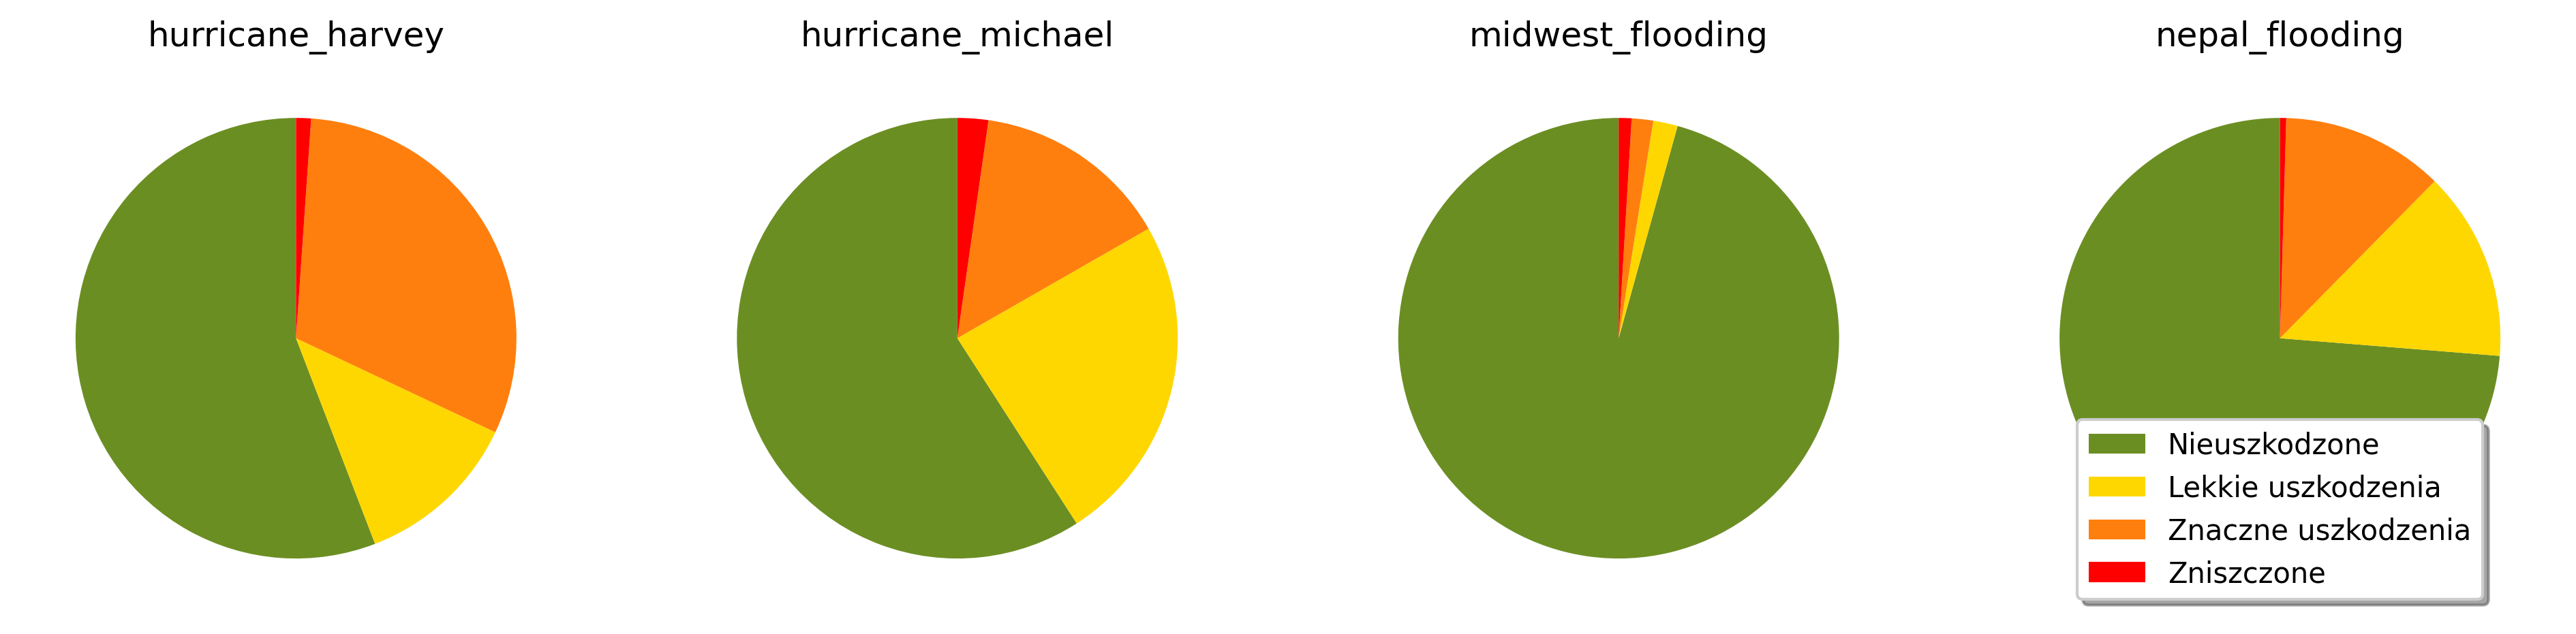

In [6]:
plot_pie_charts(densities, labels=[
    "hurricane_harvey",
    "hurricane_michael",
    "midwest_flooding",
    "nepal_flooding",
])